# Deterministic Linear Transport equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial r}{\partial t} + v\frac{\partial j}{\partial x} = \frac{\sigma(x, z)}{\epsilon^2}(\hat{r} - r), \\
&\frac{\partial j}{\partial t} + \frac{v}{\epsilon^2}\frac{\partial r}{\partial x} = - \frac{\sigma(x, z)}{\epsilon^2}j, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number, $v \in [-1, 1]$, and $\hat{r} = \int_{0}^{1} rdv$. 

It seems to me that $v$ follows a uniform distribution (as Gauss-Legendre quadrature is used to compute the integral).

We let $\sigma(x, z) \equiv 1$.

BC:
$$
r(0, t, v) = 1, \ r(1, t, v) = 0, \ j(0, t, v) = 0, j(1, t, v) = 0.
$$

IC:
$$
\begin{aligned}
&r(x, 0, v) = 1, \ 0 \le x < 0.5, \\
&r(x, 0, v) = 0, \ 0.5 \le x \le 1, \\
&j(x, 0, v) = 0.
\end{aligned}
$$

Domain:
$$
(x, t, v) \in [0, 1]\times [0, 0.01] \times [0, 1].
$$

In [1]:
NAME = "4_1e-8_dirichlet_bc"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [32]*4 + [2] # (x, t, v) -> (r, j)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_r, w_j)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[0., 0., 0.], [1., 0.01, 1.0]])

sigma = 1.0
epsilon = 1e-8

@jax.jit
def model(params, xtv): # for predictions
	# linear scaling
	xtv = (2*xtv - (domain[0, :]+domain[1, :]))/(domain[1, :] - domain[0, :])
	for w, b in params[:-1]:
		xtv = jnp.sin(jnp.dot(xtv, w) + b)
	return jnp.dot(xtv, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def quadrature(params, x, t, v, w):
	xt_ = jnp.repeat(jnp.hstack([x, t]), w.shape[0], axis = 0)
	v_ = jnp.tile(v, (x.shape[0], 1))
	rj = model(params, jnp.hstack([xt_, v_]))
	r = rj[:, 0:1].reshape((x.shape[0], w.shape[0]))
	return jnp.dot(r, w)

# jacobian[i] = [[dr/dx, dr/dt, dr/dv],
#                [dj/dx, dj/dt, dj/dv]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, bc, quad = batch["collocation"], batch["dirichlet"], batch["bc"], batch["quad"]
	direct_params = params
	
	if collocation[0] is not None:
		rj_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		r_c, j_c = rj_c[:, 0:1], rj_c[:, 1:2]
		drj_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		dr_dt_c, dj_dt_c = drj_dxtv_c[:, 0:1, 1], drj_dxtv_c[:, 1:2, 1]
		dr_dx_c, dj_dx_c = drj_dxtv_c[:, 0:1, 0], drj_dxtv_c[:, 1:2, 0]
		
		# quad.w: [q, 1]
		# quad.v: [q, 1]
		r_hat_c = quadrature(direct_params, collocation.x, collocation.t, quad.v, quad.w)
		
		loss_c1 = metaloss(epsilon**2*(dr_dt_c + collocation.v*dj_dx_c), sigma*(r_hat_c - r_c))
		loss_c2 = metaloss(epsilon**2*dj_dt_c + collocation.v*dr_dx_c, -sigma*j_c)
	else:
		loss_c1 = loss_c2 = 0
        
	if dirichlet[0] is not None:
		rj_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t, dirichlet.v]))
		r_d, j_d = rj_d[:, 0:1], rj_d[:, 1:2]
		loss_dr = metaloss(r_d, dirichlet.r)
		loss_dj = metaloss(j_d, dirichlet.j)
	else:
		loss_dr = loss_dj = 0.0
		
	if bc[0] is not None:
		rj_bl = model(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
		rj_br = model(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
		r_bl, j_bl = rj_bl[:, 0:1], rj_bl[:, 1:2]
		r_br, j_br = rj_br[:, 0:1], rj_br[:, 1:2]
		loss_bl = metaloss(r_bl, 1) + metaloss(j_bl, 0)
		loss_br = metaloss(r_br, 0) + metaloss(j_br, 0)

	return loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["dr"]*loss_dr + w["dj"]*loss_dj + w["bl"]*loss_bl + w["br"]*loss_br + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["dr"]*loss_dr + w["dj"]*loss_dj + w["bl"]*loss_bl + w["br"]*loss_br, \
			loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br, l1, l2

In [5]:
r0_fn = lambda x, t, v: jnp.select([x < 0.5, x >= 0.5], [1.0, 0.0])
j0_fn = lambda x, t, v: jnp.zeros_like(x)

key, *subkeys = random.split(key, 3)

n_quad = 16
v_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)
v_quad = jnp.array(0.5*(v_quad+1), dtype = jnp.float32).reshape((-1, 1))
w_quad = jnp.array(0.5*w_quad, dtype = jnp.float32).reshape((-1, 1))

n_i = 200
x_i = jnp.linspace(*domain[:, 0], n_i)
v_i = v_quad
xv_i = tensor_grid([x_i, v_i])
x_i, v_i = xv_i[:, 0:1], xv_i[:, 1:2]
t_i = jnp.zeros_like(x_i)
r_i = r0_fn(x_i, t_i, v_i)
j_i = j0_fn(x_i, t_i, v_i)

n_b = 100
t_b = jnp.linspace(*domain[:, 1], n_b)
v_b = v_quad
tv_b = tensor_grid([t_b, v_b])
t_b, v_b = tv_b[:, 0:1], tv_b[:, 1:2]
x_bl = jnp.ones_like(t_b)*domain[0, 0]
x_br = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 200
n_ct = 200
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
v_c = v_quad
# n_cv = 200
# v_c = jnp.linspace(*domain[:, 2], n_cv).reshape((-1, 1))
xtv_c = tensor_grid([x_c, t_c, v_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "v", "r", "j"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t", "v"])
dataset_Quad = namedtuple("dataset_Quad", ["w", "v"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t", "v"])

dirichlet = dataset_Dirichlet(x_i, t_i, v_i, r_i, j_i)
collocation = dataset_Collocation(xtv_c[:, 0:1], xtv_c[:, 1:2], xtv_c[:, 2:3])
quad = dataset_Quad(w_quad, v_quad)
bc = dataset_BC(x_bl, x_br, t_b, v_b)

In [6]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 320, "collocation": 20000, "bc": 160}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], bc, batch_size["bc"])

start_iteration = 0
iterations = 50000
print_every = 100
save_every = 10000
weights = {"c1": 10.0, "c2": 1.0, "dr": 1.0, "dj": 1.0, "bl": 1.0, "br": 1.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "bl", "br", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
# 			"collocation": dataset_Collocation(*Collocation.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 11:53:04, Iteration: 0, Train Loss: 1.8786e+00, c1: 1.0689e-02, c2: 1.2389e-01, dr: 5.0349e-01, dj: 6.4635e-02, bl: 9.2026e-01, br: 1.5948e-01, l1_reg: 3.0202e+02, l2_reg: 4.2664e+01
2020/08/28, 11:53:06, Iteration: 100, Train Loss: 7.8976e-01, c1: 3.1401e-03, c2: 4.9039e-01, dr: 2.4535e-01, dj: 1.1202e-03, bl: 1.1024e-02, br: 1.0484e-02, l1_reg: 3.0382e+02, l2_reg: 4.3030e+01
2020/08/28, 11:53:07, Iteration: 200, Train Loss: 7.7994e-01, c1: 2.5870e-03, c2: 4.9762e-01, dr: 2.3755e-01, dj: 2.2351e-03, bl: 1.0590e-02, br: 6.0738e-03, l1_reg: 3.0328e+02, l2_reg: 4.2883e+01
2020/08/28, 11:53:09, Iteration: 300, Train Loss: 7.5202e-01, c1: 7.7552e-04, c2: 4.9601e-01, dr: 2.3472e-01, dj: 1.2894e-03, bl: 7.2819e-03, br: 4.9673e-03, l1_reg: 3.0280e+02, l2_reg: 4.2772e+01
2020/08/28, 11:53:11, Iteration: 400, Train Loss: 7.4372e-01, c1: 5.7931e-04, c2: 4.9096e-01, dr: 2.3301e-01, dj: 1.6342e-03, bl: 8.6883e-03, br: 3.6316e-03, l1_reg: 3.0257e+02, l2_reg: 4.2750e+01
2020/08/28, 11:53

2020/08/28, 11:54:11, Iteration: 4200, Train Loss: 2.0679e-01, c1: 1.0466e-03, c2: 1.1588e-01, dr: 4.9605e-02, dj: 7.3239e-03, bl: 1.1867e-02, br: 1.1643e-02, l1_reg: 3.6752e+02, l2_reg: 7.4326e+01
2020/08/28, 11:54:13, Iteration: 4300, Train Loss: 1.8943e-01, c1: 1.0106e-03, c2: 1.1285e-01, dr: 4.9355e-02, dj: 4.3061e-03, bl: 5.0584e-03, br: 7.7486e-03, l1_reg: 3.6812e+02, l2_reg: 7.4612e+01
2020/08/28, 11:54:14, Iteration: 4400, Train Loss: 1.9491e-01, c1: 9.6886e-04, c2: 1.1135e-01, dr: 4.8141e-02, dj: 7.2383e-03, bl: 5.5797e-03, br: 1.2920e-02, l1_reg: 3.6876e+02, l2_reg: 7.4917e+01
2020/08/28, 11:54:16, Iteration: 4500, Train Loss: 1.9223e-01, c1: 9.3903e-04, c2: 1.0943e-01, dr: 4.8216e-02, dj: 6.8290e-03, bl: 1.4275e-02, br: 4.0881e-03, l1_reg: 3.6945e+02, l2_reg: 7.5241e+01
2020/08/28, 11:54:17, Iteration: 4600, Train Loss: 2.0582e-01, c1: 9.5691e-04, c2: 1.0630e-01, dr: 4.9303e-02, dj: 8.8479e-03, bl: 9.7534e-03, br: 2.2049e-02, l1_reg: 3.7013e+02, l2_reg: 7.5571e+01
2020/08/28

2020/08/28, 11:55:18, Iteration: 8400, Train Loss: 1.2637e-01, c1: 6.4519e-04, c2: 6.6700e-02, dr: 2.9991e-02, dj: 5.2731e-03, bl: 1.2890e-02, br: 5.0611e-03, l1_reg: 3.9853e+02, l2_reg: 9.0487e+01
2020/08/28, 11:55:19, Iteration: 8500, Train Loss: 1.2150e-01, c1: 7.1256e-04, c2: 6.5394e-02, dr: 3.0140e-02, dj: 4.1338e-03, bl: 9.6771e-03, br: 5.0265e-03, l1_reg: 3.9919e+02, l2_reg: 9.0820e+01
2020/08/28, 11:55:21, Iteration: 8600, Train Loss: 1.2500e-01, c1: 6.0654e-04, c2: 6.5312e-02, dr: 2.9337e-02, dj: 5.7636e-03, bl: 7.4391e-03, br: 1.1084e-02, l1_reg: 3.9983e+02, l2_reg: 9.1165e+01
2020/08/28, 11:55:23, Iteration: 8700, Train Loss: 1.2683e-01, c1: 6.7748e-04, c2: 6.2815e-02, dr: 3.0469e-02, dj: 7.5196e-03, bl: 7.9682e-03, br: 1.1285e-02, l1_reg: 4.0044e+02, l2_reg: 9.1470e+01
2020/08/28, 11:55:24, Iteration: 8800, Train Loss: 1.2299e-01, c1: 6.3633e-04, c2: 5.6351e-02, dr: 2.8785e-02, dj: 1.1573e-02, bl: 4.6225e-03, br: 1.5293e-02, l1_reg: 4.0111e+02, l2_reg: 9.1805e+01
2020/08/28

2020/08/28, 11:56:24, Iteration: 12600, Train Loss: 8.8486e-02, c1: 4.7176e-04, c2: 4.5695e-02, dr: 2.2129e-02, dj: 2.8495e-03, bl: 7.0111e-03, br: 6.0842e-03, l1_reg: 4.1828e+02, l2_reg: 1.0121e+02
2020/08/28, 11:56:26, Iteration: 12700, Train Loss: 9.9672e-02, c1: 4.2355e-04, c2: 5.1057e-02, dr: 2.2717e-02, dj: 5.0240e-03, bl: 5.6260e-03, br: 1.1013e-02, l1_reg: 4.1860e+02, l2_reg: 1.0139e+02
2020/08/28, 11:56:28, Iteration: 12800, Train Loss: 9.6703e-02, c1: 3.9125e-04, c2: 5.4166e-02, dr: 2.1568e-02, dj: 3.5920e-03, bl: 1.0385e-02, br: 3.0794e-03, l1_reg: 4.1892e+02, l2_reg: 1.0159e+02
2020/08/28, 11:56:29, Iteration: 12900, Train Loss: 9.7208e-02, c1: 5.7994e-04, c2: 4.7438e-02, dr: 2.1802e-02, dj: 5.9500e-03, bl: 9.1095e-03, br: 7.1092e-03, l1_reg: 4.1926e+02, l2_reg: 1.0180e+02
2020/08/28, 11:56:31, Iteration: 13000, Train Loss: 9.9573e-02, c1: 7.3465e-04, c2: 4.6742e-02, dr: 2.2606e-02, dj: 4.0923e-03, bl: 1.1270e-02, br: 7.5162e-03, l1_reg: 4.1954e+02, l2_reg: 1.0197e+02
2020/

2020/08/28, 11:57:31, Iteration: 16800, Train Loss: 9.8313e-02, c1: 5.2371e-04, c2: 4.6818e-02, dr: 2.1065e-02, dj: 5.2230e-03, bl: 1.1297e-02, br: 8.6725e-03, l1_reg: 4.2831e+02, l2_reg: 1.0739e+02
2020/08/28, 11:57:33, Iteration: 16900, Train Loss: 8.9269e-02, c1: 3.3946e-04, c2: 4.3344e-02, dr: 1.9538e-02, dj: 6.2991e-03, bl: 1.0474e-02, br: 6.2197e-03, l1_reg: 4.2855e+02, l2_reg: 1.0753e+02
2020/08/28, 11:57:34, Iteration: 17000, Train Loss: 8.0845e-02, c1: 3.6840e-04, c2: 4.1524e-02, dr: 1.9861e-02, dj: 3.5078e-03, bl: 5.5462e-03, br: 6.7215e-03, l1_reg: 4.2874e+02, l2_reg: 1.0765e+02
2020/08/28, 11:57:36, Iteration: 17100, Train Loss: 8.5318e-02, c1: 4.4800e-04, c2: 4.2770e-02, dr: 1.9092e-02, dj: 5.4707e-03, bl: 4.4238e-03, br: 9.0818e-03, l1_reg: 4.2895e+02, l2_reg: 1.0778e+02
2020/08/28, 11:57:38, Iteration: 17200, Train Loss: 9.3081e-02, c1: 4.2764e-04, c2: 4.8443e-02, dr: 2.0825e-02, dj: 4.5578e-03, bl: 6.2133e-03, br: 8.7648e-03, l1_reg: 4.2913e+02, l2_reg: 1.0792e+02
2020/

2020/08/28, 11:58:38, Iteration: 21000, Train Loss: 8.6385e-02, c1: 5.5359e-04, c2: 4.1482e-02, dr: 1.7692e-02, dj: 5.5140e-03, bl: 9.0486e-03, br: 7.1121e-03, l1_reg: 4.3629e+02, l2_reg: 1.1266e+02
2020/08/28, 11:58:39, Iteration: 21100, Train Loss: 7.5450e-02, c1: 4.1750e-04, c2: 3.7214e-02, dr: 1.8283e-02, dj: 4.7932e-03, bl: 5.0183e-03, br: 5.9654e-03, l1_reg: 4.3645e+02, l2_reg: 1.1277e+02
2020/08/28, 11:58:41, Iteration: 21200, Train Loss: 8.6419e-02, c1: 3.9303e-04, c2: 3.7046e-02, dr: 1.7966e-02, dj: 6.5147e-03, bl: 1.0981e-02, br: 9.9810e-03, l1_reg: 4.3664e+02, l2_reg: 1.1290e+02
2020/08/28, 11:58:43, Iteration: 21300, Train Loss: 8.0735e-02, c1: 3.0828e-04, c2: 4.5926e-02, dr: 1.7495e-02, dj: 3.8614e-03, bl: 7.0782e-03, br: 3.2921e-03, l1_reg: 4.3686e+02, l2_reg: 1.1304e+02
2020/08/28, 11:58:44, Iteration: 21400, Train Loss: 8.9050e-02, c1: 3.2162e-04, c2: 4.1410e-02, dr: 1.9272e-02, dj: 6.3192e-03, bl: 8.7916e-03, br: 1.0041e-02, l1_reg: 4.3708e+02, l2_reg: 1.1319e+02
2020/

2020/08/28, 11:59:45, Iteration: 25200, Train Loss: 7.1001e-02, c1: 3.4236e-04, c2: 3.6431e-02, dr: 1.6275e-02, dj: 5.2325e-03, bl: 3.5008e-03, br: 6.1373e-03, l1_reg: 4.4365e+02, l2_reg: 1.1781e+02
2020/08/28, 11:59:46, Iteration: 25300, Train Loss: 7.9544e-02, c1: 4.2923e-04, c2: 3.3215e-02, dr: 1.5861e-02, dj: 6.8733e-03, bl: 1.0061e-02, br: 9.2414e-03, l1_reg: 4.4379e+02, l2_reg: 1.1790e+02
2020/08/28, 11:59:48, Iteration: 25400, Train Loss: 6.4803e-02, c1: 2.7074e-04, c2: 3.1243e-02, dr: 1.6463e-02, dj: 4.7953e-03, bl: 3.2083e-03, br: 6.3855e-03, l1_reg: 4.4397e+02, l2_reg: 1.1803e+02
2020/08/28, 11:59:49, Iteration: 25500, Train Loss: 7.8959e-02, c1: 2.7289e-04, c2: 4.1522e-02, dr: 1.6372e-02, dj: 3.0579e-03, bl: 5.7646e-03, br: 9.5142e-03, l1_reg: 4.4416e+02, l2_reg: 1.1815e+02
2020/08/28, 11:59:51, Iteration: 25600, Train Loss: 8.0563e-02, c1: 3.6645e-04, c2: 3.7257e-02, dr: 1.7575e-02, dj: 6.0776e-03, bl: 1.2271e-02, br: 3.7169e-03, l1_reg: 4.4432e+02, l2_reg: 1.1825e+02
2020/

2020/08/28, 12:00:51, Iteration: 29400, Train Loss: 7.1272e-02, c1: 3.7926e-04, c2: 3.5593e-02, dr: 1.5323e-02, dj: 3.8706e-03, bl: 8.1601e-03, br: 4.5330e-03, l1_reg: 4.5010e+02, l2_reg: 1.2231e+02
2020/08/28, 12:00:53, Iteration: 29500, Train Loss: 6.5766e-02, c1: 3.3645e-04, c2: 3.7862e-02, dr: 1.5148e-02, dj: 3.5192e-03, bl: 2.4919e-03, br: 3.3805e-03, l1_reg: 4.5027e+02, l2_reg: 1.2242e+02
2020/08/28, 12:00:55, Iteration: 29600, Train Loss: 6.4065e-02, c1: 3.2004e-04, c2: 3.2807e-02, dr: 1.5721e-02, dj: 2.8585e-03, bl: 4.6197e-03, br: 4.8589e-03, l1_reg: 4.5040e+02, l2_reg: 1.2251e+02
2020/08/28, 12:00:56, Iteration: 29700, Train Loss: 7.6423e-02, c1: 2.8236e-04, c2: 3.6463e-02, dr: 1.4651e-02, dj: 4.0720e-03, bl: 6.4727e-03, br: 1.1941e-02, l1_reg: 4.5056e+02, l2_reg: 1.2261e+02
2020/08/28, 12:00:58, Iteration: 29800, Train Loss: 6.6641e-02, c1: 5.3441e-04, c2: 3.3677e-02, dr: 1.5422e-02, dj: 4.3289e-03, bl: 4.4383e-03, br: 3.4309e-03, l1_reg: 4.5073e+02, l2_reg: 1.2273e+02
2020/

2020/08/28, 12:01:58, Iteration: 33600, Train Loss: 6.7385e-02, c1: 3.0039e-04, c2: 3.4478e-02, dr: 1.4665e-02, dj: 3.7739e-03, bl: 2.8202e-03, br: 8.6437e-03, l1_reg: 4.5594e+02, l2_reg: 1.2638e+02
2020/08/28, 12:01:59, Iteration: 33700, Train Loss: 6.3253e-02, c1: 2.9844e-04, c2: 3.4591e-02, dr: 1.5109e-02, dj: 3.3861e-03, bl: 3.7354e-03, br: 3.4463e-03, l1_reg: 4.5601e+02, l2_reg: 1.2644e+02
2020/08/28, 12:02:01, Iteration: 33800, Train Loss: 5.9772e-02, c1: 3.0644e-04, c2: 3.2135e-02, dr: 1.3927e-02, dj: 4.4319e-03, bl: 3.8798e-03, br: 2.3336e-03, l1_reg: 4.5611e+02, l2_reg: 1.2652e+02
2020/08/28, 12:02:03, Iteration: 33900, Train Loss: 5.8974e-02, c1: 3.4699e-04, c2: 2.9764e-02, dr: 1.3932e-02, dj: 5.7049e-03, bl: 2.5289e-03, br: 3.5743e-03, l1_reg: 4.5622e+02, l2_reg: 1.2659e+02
2020/08/28, 12:02:04, Iteration: 34000, Train Loss: 7.1250e-02, c1: 2.5070e-04, c2: 3.3000e-02, dr: 1.4377e-02, dj: 4.0074e-03, bl: 1.1115e-02, br: 6.2449e-03, l1_reg: 4.5634e+02, l2_reg: 1.2668e+02
2020/

2020/08/28, 12:03:05, Iteration: 37800, Train Loss: 6.6847e-02, c1: 3.5729e-04, c2: 3.5841e-02, dr: 1.3545e-02, dj: 3.1606e-03, bl: 5.2974e-03, br: 5.4296e-03, l1_reg: 4.6075e+02, l2_reg: 1.2992e+02
2020/08/28, 12:03:06, Iteration: 37900, Train Loss: 5.6003e-02, c1: 2.5847e-04, c2: 2.7783e-02, dr: 1.3410e-02, dj: 2.2472e-03, bl: 5.9801e-03, br: 3.9979e-03, l1_reg: 4.6087e+02, l2_reg: 1.3001e+02
2020/08/28, 12:03:08, Iteration: 38000, Train Loss: 6.7884e-02, c1: 3.4558e-04, c2: 3.3728e-02, dr: 1.3793e-02, dj: 5.4929e-03, bl: 5.0705e-03, br: 6.3441e-03, l1_reg: 4.6097e+02, l2_reg: 1.3009e+02
2020/08/28, 12:03:09, Iteration: 38100, Train Loss: 6.3625e-02, c1: 2.5883e-04, c2: 2.7698e-02, dr: 1.4598e-02, dj: 3.9494e-03, bl: 6.4597e-03, br: 8.3324e-03, l1_reg: 4.6106e+02, l2_reg: 1.3016e+02
2020/08/28, 12:03:11, Iteration: 38200, Train Loss: 6.5035e-02, c1: 2.9099e-04, c2: 3.0913e-02, dr: 1.3215e-02, dj: 2.1225e-03, bl: 1.0406e-02, br: 5.4684e-03, l1_reg: 4.6121e+02, l2_reg: 1.3027e+02
2020/

2020/08/28, 12:04:11, Iteration: 42000, Train Loss: 6.4681e-02, c1: 3.4733e-04, c2: 3.3847e-02, dr: 1.2426e-02, dj: 2.8536e-03, bl: 6.8840e-03, br: 5.1977e-03, l1_reg: 4.6617e+02, l2_reg: 1.3365e+02
2020/08/28, 12:04:13, Iteration: 42100, Train Loss: 5.4371e-02, c1: 2.5585e-04, c2: 3.2974e-02, dr: 1.2302e-02, dj: 2.1603e-03, bl: 2.9430e-03, br: 1.4336e-03, l1_reg: 4.6632e+02, l2_reg: 1.3374e+02
2020/08/28, 12:04:14, Iteration: 42200, Train Loss: 5.7254e-02, c1: 2.8239e-04, c2: 3.0100e-02, dr: 1.2343e-02, dj: 3.0116e-03, bl: 5.6184e-03, br: 3.3570e-03, l1_reg: 4.6648e+02, l2_reg: 1.3384e+02
2020/08/28, 12:04:16, Iteration: 42300, Train Loss: 4.8921e-02, c1: 2.3811e-04, c2: 2.4188e-02, dr: 1.2988e-02, dj: 2.8706e-03, bl: 2.5463e-03, br: 3.9473e-03, l1_reg: 4.6660e+02, l2_reg: 1.3392e+02
2020/08/28, 12:04:18, Iteration: 42400, Train Loss: 6.6017e-02, c1: 3.4248e-04, c2: 3.2543e-02, dr: 1.3123e-02, dj: 4.6691e-03, bl: 6.7304e-03, br: 5.5264e-03, l1_reg: 4.6674e+02, l2_reg: 1.3400e+02
2020/

2020/08/28, 12:05:18, Iteration: 46200, Train Loss: 6.1873e-02, c1: 2.6037e-04, c2: 2.7699e-02, dr: 1.2607e-02, dj: 9.2920e-03, bl: 3.6328e-03, br: 6.0381e-03, l1_reg: 4.7159e+02, l2_reg: 1.3734e+02
2020/08/28, 12:05:20, Iteration: 46300, Train Loss: 6.1848e-02, c1: 3.0432e-04, c2: 3.0826e-02, dr: 1.2512e-02, dj: 3.7787e-03, bl: 6.3538e-03, br: 5.3342e-03, l1_reg: 4.7172e+02, l2_reg: 1.3744e+02
2020/08/28, 12:05:22, Iteration: 46400, Train Loss: 6.0448e-02, c1: 2.9592e-04, c2: 2.7685e-02, dr: 1.2183e-02, dj: 5.9232e-03, bl: 5.5204e-03, br: 6.1776e-03, l1_reg: 4.7187e+02, l2_reg: 1.3754e+02
2020/08/28, 12:05:23, Iteration: 46500, Train Loss: 5.4523e-02, c1: 2.7807e-04, c2: 2.8407e-02, dr: 1.2099e-02, dj: 2.4684e-03, bl: 5.8412e-03, br: 2.9268e-03, l1_reg: 4.7199e+02, l2_reg: 1.3762e+02
2020/08/28, 12:05:25, Iteration: 46600, Train Loss: 5.7605e-02, c1: 2.5290e-04, c2: 3.2305e-02, dr: 1.1812e-02, dj: 4.7039e-03, bl: 4.1018e-03, br: 2.1529e-03, l1_reg: 4.7209e+02, l2_reg: 1.3769e+02
2020/

In [7]:
start_iteration = 50000
iterations = 500000
print_every = 1000
save_every = 10000
weights = {"c1": 10.0, "c2": 1.0, "dr": 1.0, "dj": 1.0, "bl": 1.0, "br": 1.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "bl", "br", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
# 			"collocation": dataset_Collocation(*Collocation.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 12:06:19, Iteration: 50000, Train Loss: 5.3481e-02, c1: 2.3013e-04, c2: 2.9402e-02, dr: 1.1272e-02, dj: 6.4019e-03, bl: 1.4928e-03, br: 2.6104e-03, l1_reg: 4.7659e+02, l2_reg: 1.4078e+02
2020/08/28, 12:06:34, Iteration: 51000, Train Loss: 7.1550e-02, c1: 3.4211e-04, c2: 3.9987e-02, dr: 1.1966e-02, dj: 5.0858e-03, bl: 6.8671e-03, br: 4.2239e-03, l1_reg: 4.7789e+02, l2_reg: 1.4171e+02
2020/08/28, 12:06:50, Iteration: 52000, Train Loss: 6.3037e-02, c1: 2.8573e-04, c2: 3.1666e-02, dr: 1.1068e-02, dj: 7.9421e-03, bl: 4.7983e-03, br: 4.7051e-03, l1_reg: 4.7918e+02, l2_reg: 1.4266e+02
2020/08/28, 12:07:06, Iteration: 53000, Train Loss: 5.1243e-02, c1: 2.7386e-04, c2: 2.7719e-02, dr: 1.1174e-02, dj: 2.5884e-03, bl: 2.1366e-03, br: 4.8865e-03, l1_reg: 4.8058e+02, l2_reg: 1.4363e+02
2020/08/28, 12:07:22, Iteration: 54000, Train Loss: 5.2328e-02, c1: 2.3813e-04, c2: 2.4297e-02, dr: 1.1279e-02, dj: 6.3250e-03, bl: 3.4620e-03, br: 4.5832e-03, l1_reg: 4.8190e+02, l2_reg: 1.4458e+02
2020/

2020/08/28, 12:17:21, Iteration: 92000, Train Loss: 3.4892e-02, c1: 1.5485e-04, c2: 2.0165e-02, dr: 8.1203e-03, dj: 2.4715e-03, bl: 1.6583e-03, br: 9.2852e-04, l1_reg: 5.1440e+02, l2_reg: 1.7259e+02
2020/08/28, 12:17:36, Iteration: 93000, Train Loss: 4.0849e-02, c1: 2.0198e-04, c2: 2.3067e-02, dr: 8.0987e-03, dj: 3.6128e-03, bl: 2.6197e-03, br: 1.4311e-03, l1_reg: 5.1492e+02, l2_reg: 1.7321e+02
2020/08/28, 12:17:52, Iteration: 94000, Train Loss: 4.1873e-02, c1: 1.9389e-04, c2: 2.4569e-02, dr: 7.8407e-03, dj: 2.7081e-03, bl: 1.9545e-03, br: 2.8618e-03, l1_reg: 5.1547e+02, l2_reg: 1.7388e+02
2020/08/28, 12:18:08, Iteration: 95000, Train Loss: 3.7511e-02, c1: 2.0983e-04, c2: 2.1595e-02, dr: 8.1974e-03, dj: 2.8234e-03, bl: 8.9302e-04, br: 1.9041e-03, l1_reg: 5.1601e+02, l2_reg: 1.7452e+02
2020/08/28, 12:18:24, Iteration: 96000, Train Loss: 5.1553e-02, c1: 2.3131e-04, c2: 3.0797e-02, dr: 7.9609e-03, dj: 4.4172e-03, bl: 3.3053e-03, br: 2.7598e-03, l1_reg: 5.1660e+02, l2_reg: 1.7518e+02
2020/

2020/08/28, 12:28:24, Iteration: 134000, Train Loss: 3.6996e-02, c1: 1.5926e-04, c2: 2.0995e-02, dr: 6.0629e-03, dj: 4.0416e-03, bl: 1.3112e-03, br: 2.9928e-03, l1_reg: 5.3288e+02, l2_reg: 1.9397e+02
2020/08/28, 12:28:39, Iteration: 135000, Train Loss: 4.8069e-02, c1: 1.6047e-04, c2: 3.2940e-02, dr: 6.3189e-03, dj: 4.2970e-03, bl: 1.7536e-03, br: 1.1550e-03, l1_reg: 5.3325e+02, l2_reg: 1.9452e+02
2020/08/28, 12:28:55, Iteration: 136000, Train Loss: 4.2804e-02, c1: 1.3271e-04, c2: 2.2365e-02, dr: 6.4904e-03, dj: 6.8163e-03, bl: 4.4304e-03, br: 1.3753e-03, l1_reg: 5.3381e+02, l2_reg: 1.9514e+02
2020/08/28, 12:29:11, Iteration: 137000, Train Loss: 5.0864e-02, c1: 2.3028e-04, c2: 2.5157e-02, dr: 7.1793e-03, dj: 8.3545e-03, bl: 3.5440e-03, br: 4.3270e-03, l1_reg: 5.3420e+02, l2_reg: 1.9568e+02
2020/08/28, 12:29:27, Iteration: 138000, Train Loss: 2.9872e-02, c1: 1.4334e-04, c2: 1.4631e-02, dr: 6.3016e-03, dj: 2.7130e-03, bl: 2.3389e-03, br: 2.4544e-03, l1_reg: 5.3465e+02, l2_reg: 1.9628e+02


2020/08/28, 12:39:11, Iteration: 175000, Train Loss: 3.0214e-02, c1: 1.2183e-04, c2: 1.7675e-02, dr: 5.2425e-03, dj: 1.5399e-03, bl: 2.2923e-03, br: 2.2462e-03, l1_reg: 5.5765e+02, l2_reg: 2.2006e+02
2020/08/28, 12:39:27, Iteration: 176000, Train Loss: 3.2914e-02, c1: 1.7868e-04, c2: 1.6822e-02, dr: 6.0872e-03, dj: 3.5235e-03, bl: 2.2878e-03, br: 2.4068e-03, l1_reg: 5.5831e+02, l2_reg: 2.2071e+02
2020/08/28, 12:39:42, Iteration: 177000, Train Loss: 2.9717e-02, c1: 1.2303e-04, c2: 1.7803e-02, dr: 5.0611e-03, dj: 1.2015e-03, bl: 2.8962e-03, br: 1.5246e-03, l1_reg: 5.5893e+02, l2_reg: 2.2133e+02
2020/08/28, 12:39:58, Iteration: 178000, Train Loss: 3.2070e-02, c1: 1.3041e-04, c2: 1.8921e-02, dr: 5.3187e-03, dj: 2.5968e-03, bl: 1.4413e-03, br: 2.4877e-03, l1_reg: 5.5971e+02, l2_reg: 2.2198e+02
2020/08/28, 12:40:13, Iteration: 179000, Train Loss: 3.6449e-02, c1: 1.6016e-04, c2: 2.1398e-02, dr: 5.3115e-03, dj: 4.2180e-03, bl: 1.1490e-03, br: 2.7704e-03, l1_reg: 5.6035e+02, l2_reg: 2.2264e+02


2020/08/28, 12:49:56, Iteration: 216000, Train Loss: 3.0760e-02, c1: 1.9781e-04, c2: 1.8863e-02, dr: 4.4244e-03, dj: 1.3010e-03, bl: 2.2638e-03, br: 1.9301e-03, l1_reg: 5.8294e+02, l2_reg: 2.4626e+02
2020/08/28, 12:50:12, Iteration: 217000, Train Loss: 2.8323e-02, c1: 1.9266e-04, c2: 1.7798e-02, dr: 4.3761e-03, dj: 1.1956e-03, bl: 1.0399e-03, br: 1.9870e-03, l1_reg: 5.8352e+02, l2_reg: 2.4691e+02
2020/08/28, 12:50:28, Iteration: 218000, Train Loss: 2.5943e-02, c1: 1.0663e-04, c2: 1.5349e-02, dr: 4.4475e-03, dj: 1.2566e-03, bl: 1.4537e-03, br: 2.3700e-03, l1_reg: 5.8400e+02, l2_reg: 2.4753e+02
2020/08/28, 12:50:44, Iteration: 219000, Train Loss: 3.8133e-02, c1: 1.4547e-04, c2: 2.4329e-02, dr: 5.1067e-03, dj: 2.5088e-03, bl: 2.6026e-03, br: 2.1312e-03, l1_reg: 5.8475e+02, l2_reg: 2.4831e+02
2020/08/28, 12:51:00, Iteration: 220000, Train Loss: 2.7889e-02, c1: 1.2328e-04, c2: 1.8443e-02, dr: 4.1833e-03, dj: 1.9794e-03, bl: 1.1129e-03, br: 9.3807e-04, l1_reg: 5.8534e+02, l2_reg: 2.4899e+02


2020/08/28, 13:00:43, Iteration: 257000, Train Loss: 2.2839e-02, c1: 1.3056e-04, c2: 1.1364e-02, dr: 3.6657e-03, dj: 2.5561e-03, bl: 1.5918e-03, br: 2.3565e-03, l1_reg: 6.0726e+02, l2_reg: 2.7315e+02
2020/08/28, 13:00:59, Iteration: 258000, Train Loss: 2.6541e-02, c1: 1.9781e-04, c2: 1.4072e-02, dr: 4.3347e-03, dj: 1.9098e-03, bl: 1.9106e-03, br: 2.3356e-03, l1_reg: 6.0792e+02, l2_reg: 2.7378e+02
2020/08/28, 13:01:15, Iteration: 259000, Train Loss: 1.9040e-02, c1: 1.1360e-04, c2: 1.0415e-02, dr: 3.5652e-03, dj: 1.0040e-03, bl: 1.3432e-03, br: 1.5771e-03, l1_reg: 6.0848e+02, l2_reg: 2.7442e+02
2020/08/28, 13:01:30, Iteration: 260000, Train Loss: 2.7727e-02, c1: 9.1323e-05, c2: 1.7844e-02, dr: 4.0973e-03, dj: 1.6820e-03, bl: 1.7275e-03, br: 1.4635e-03, l1_reg: 6.0892e+02, l2_reg: 2.7500e+02
2020/08/28, 13:01:46, Iteration: 261000, Train Loss: 2.6998e-02, c1: 8.9465e-05, c2: 1.7144e-02, dr: 3.6156e-03, dj: 2.3237e-03, bl: 2.1261e-03, br: 8.9408e-04, l1_reg: 6.0950e+02, l2_reg: 2.7556e+02


2020/08/28, 13:11:29, Iteration: 298000, Train Loss: 2.0754e-02, c1: 1.0573e-04, c2: 1.4137e-02, dr: 3.3822e-03, dj: 1.1922e-03, bl: 5.0688e-04, br: 4.7831e-04, l1_reg: 6.3150e+02, l2_reg: 2.9977e+02
2020/08/28, 13:11:45, Iteration: 299000, Train Loss: 3.2854e-02, c1: 1.6356e-04, c2: 2.3232e-02, dr: 3.7531e-03, dj: 1.4732e-03, bl: 4.8345e-04, br: 2.2766e-03, l1_reg: 6.3212e+02, l2_reg: 3.0052e+02
2020/08/28, 13:12:01, Iteration: 300000, Train Loss: 2.3789e-02, c1: 8.2067e-05, c2: 1.6501e-02, dr: 3.4771e-03, dj: 1.0062e-03, bl: 1.2972e-03, br: 6.8709e-04, l1_reg: 6.3267e+02, l2_reg: 3.0123e+02
2020/08/28, 13:12:17, Iteration: 301000, Train Loss: 2.7711e-02, c1: 1.7327e-04, c2: 1.5899e-02, dr: 3.6255e-03, dj: 1.5246e-03, bl: 2.7771e-03, br: 2.1526e-03, l1_reg: 6.3335e+02, l2_reg: 3.0198e+02
2020/08/28, 13:12:33, Iteration: 302000, Train Loss: 2.2887e-02, c1: 1.9882e-04, c2: 1.1309e-02, dr: 3.9993e-03, dj: 1.2680e-03, bl: 2.1013e-03, br: 2.2210e-03, l1_reg: 6.3377e+02, l2_reg: 3.0268e+02


2020/08/28, 13:22:15, Iteration: 339000, Train Loss: 3.8389e-02, c1: 2.7743e-04, c2: 2.7648e-02, dr: 2.9233e-03, dj: 9.4817e-04, bl: 3.5113e-03, br: 5.8437e-04, l1_reg: 6.5506e+02, l2_reg: 3.2992e+02
2020/08/28, 13:22:31, Iteration: 340000, Train Loss: 2.0125e-02, c1: 1.6216e-04, c2: 1.1682e-02, dr: 3.0824e-03, dj: 1.1396e-03, bl: 3.6795e-04, br: 2.2315e-03, l1_reg: 6.5545e+02, l2_reg: 3.3062e+02
2020/08/28, 13:22:47, Iteration: 341000, Train Loss: 3.2639e-02, c1: 1.3655e-04, c2: 2.4197e-02, dr: 3.0127e-03, dj: 1.7409e-03, bl: 5.0795e-04, br: 1.8146e-03, l1_reg: 6.5595e+02, l2_reg: 3.3133e+02
2020/08/28, 13:23:03, Iteration: 342000, Train Loss: 2.8925e-02, c1: 9.9008e-05, c2: 2.0786e-02, dr: 2.6233e-03, dj: 1.4431e-03, bl: 1.8727e-03, br: 1.2091e-03, l1_reg: 6.5660e+02, l2_reg: 3.3203e+02
2020/08/28, 13:23:19, Iteration: 343000, Train Loss: 2.8305e-02, c1: 1.3563e-04, c2: 1.9962e-02, dr: 2.6701e-03, dj: 1.6107e-03, bl: 1.0519e-03, br: 1.6535e-03, l1_reg: 6.5688e+02, l2_reg: 3.3259e+02


2020/08/28, 13:33:03, Iteration: 380000, Train Loss: 2.0979e-02, c1: 1.1506e-04, c2: 1.5648e-02, dr: 2.2595e-03, dj: 8.9793e-04, bl: 4.2355e-04, br: 5.9913e-04, l1_reg: 6.7047e+02, l2_reg: 3.5295e+02
2020/08/28, 13:33:19, Iteration: 381000, Train Loss: 1.9442e-02, c1: 1.9206e-04, c2: 1.0520e-02, dr: 2.6334e-03, dj: 1.3725e-03, bl: 1.4945e-03, br: 1.5014e-03, l1_reg: 6.7063e+02, l2_reg: 3.5339e+02
2020/08/28, 13:33:35, Iteration: 382000, Train Loss: 2.4385e-02, c1: 1.3168e-04, c2: 1.8395e-02, dr: 2.3221e-03, dj: 8.4483e-04, bl: 8.0815e-04, br: 6.9796e-04, l1_reg: 6.7094e+02, l2_reg: 3.5390e+02
2020/08/28, 13:33:50, Iteration: 383000, Train Loss: 2.8376e-02, c1: 1.0374e-04, c2: 1.8987e-02, dr: 3.0398e-03, dj: 2.0600e-03, bl: 1.4278e-03, br: 1.8242e-03, l1_reg: 6.7130e+02, l2_reg: 3.5437e+02
2020/08/28, 13:34:06, Iteration: 384000, Train Loss: 2.5271e-02, c1: 8.9310e-05, c2: 1.7797e-02, dr: 2.8225e-03, dj: 1.4502e-03, bl: 9.2058e-04, br: 1.3871e-03, l1_reg: 6.7163e+02, l2_reg: 3.5491e+02


2020/08/28, 13:43:52, Iteration: 421000, Train Loss: 2.7978e-02, c1: 8.9071e-05, c2: 1.9767e-02, dr: 2.8258e-03, dj: 1.0075e-03, bl: 1.2463e-03, br: 2.2413e-03, l1_reg: 6.8088e+02, l2_reg: 3.7083e+02
2020/08/28, 13:44:08, Iteration: 422000, Train Loss: 3.6702e-02, c1: 1.3592e-04, c2: 2.9031e-02, dr: 2.8462e-03, dj: 7.2905e-04, bl: 1.7466e-03, br: 9.8991e-04, l1_reg: 6.8088e+02, l2_reg: 3.7115e+02
2020/08/28, 13:44:24, Iteration: 423000, Train Loss: 1.8260e-02, c1: 1.3134e-04, c2: 1.1286e-02, dr: 2.5637e-03, dj: 8.1433e-04, bl: 1.1866e-03, br: 1.0957e-03, l1_reg: 6.8107e+02, l2_reg: 3.7155e+02
2020/08/28, 13:44:39, Iteration: 424000, Train Loss: 2.6793e-02, c1: 1.2150e-04, c2: 2.0531e-02, dr: 2.4143e-03, dj: 7.4228e-04, bl: 1.1979e-03, br: 6.9170e-04, l1_reg: 6.8131e+02, l2_reg: 3.7197e+02
2020/08/28, 13:44:55, Iteration: 425000, Train Loss: 1.8339e-02, c1: 1.0317e-04, c2: 9.3609e-03, dr: 2.4718e-03, dj: 1.8083e-03, bl: 2.0740e-03, br: 1.5928e-03, l1_reg: 6.8159e+02, l2_reg: 3.7239e+02


2020/08/28, 13:54:38, Iteration: 462000, Train Loss: 2.1839e-02, c1: 1.7771e-04, c2: 1.2544e-02, dr: 2.6467e-03, dj: 2.1226e-03, bl: 8.6773e-04, br: 1.8805e-03, l1_reg: 6.9085e+02, l2_reg: 3.8688e+02
2020/08/28, 13:54:54, Iteration: 463000, Train Loss: 2.1053e-02, c1: 1.3014e-04, c2: 1.0668e-02, dr: 3.5205e-03, dj: 7.1315e-04, bl: 1.6877e-03, br: 3.1629e-03, l1_reg: 6.9109e+02, l2_reg: 3.8729e+02
2020/08/28, 13:55:10, Iteration: 464000, Train Loss: 3.3379e-02, c1: 1.0512e-04, c2: 2.5739e-02, dr: 2.7264e-03, dj: 9.3515e-04, bl: 1.3364e-03, br: 1.5909e-03, l1_reg: 6.9116e+02, l2_reg: 3.8772e+02
2020/08/28, 13:55:26, Iteration: 465000, Train Loss: 2.0124e-02, c1: 9.0662e-05, c2: 1.0841e-02, dr: 3.2590e-03, dj: 1.1406e-03, bl: 2.1867e-03, br: 1.7898e-03, l1_reg: 6.9161e+02, l2_reg: 3.8803e+02
2020/08/28, 13:55:41, Iteration: 466000, Train Loss: 1.6638e-02, c1: 2.1746e-04, c2: 8.5636e-03, dr: 2.6664e-03, dj: 6.1505e-04, bl: 8.6477e-04, br: 1.7534e-03, l1_reg: 6.9195e+02, l2_reg: 3.8848e+02


2020/08/28, 14:05:24, Iteration: 503000, Train Loss: 2.7521e-02, c1: 1.1626e-04, c2: 1.9635e-02, dr: 2.3194e-03, dj: 1.3714e-03, bl: 9.1566e-04, br: 2.1165e-03, l1_reg: 7.0201e+02, l2_reg: 4.0499e+02
2020/08/28, 14:05:40, Iteration: 504000, Train Loss: 2.0881e-02, c1: 1.0889e-04, c2: 1.4535e-02, dr: 2.2528e-03, dj: 9.6758e-04, bl: 1.5721e-03, br: 4.6409e-04, l1_reg: 7.0270e+02, l2_reg: 4.0572e+02
2020/08/28, 14:05:56, Iteration: 505000, Train Loss: 1.0250e-02, c1: 7.2130e-05, c2: 5.0339e-03, dr: 2.0868e-03, dj: 1.3698e-03, bl: 6.1612e-04, br: 4.2156e-04, l1_reg: 7.0297e+02, l2_reg: 4.0652e+02
2020/08/28, 14:06:11, Iteration: 506000, Train Loss: 2.3262e-02, c1: 7.4277e-05, c2: 1.7269e-02, dr: 2.3320e-03, dj: 1.0974e-03, bl: 1.1202e-03, br: 6.9999e-04, l1_reg: 7.0346e+02, l2_reg: 4.0731e+02
2020/08/28, 14:06:27, Iteration: 507000, Train Loss: 2.3488e-02, c1: 1.1565e-04, c2: 1.6828e-02, dr: 1.9904e-03, dj: 1.3584e-03, bl: 1.2778e-03, br: 8.7720e-04, l1_reg: 7.0389e+02, l2_reg: 4.0818e+02


2020/08/28, 14:16:12, Iteration: 544000, Train Loss: 1.7158e-02, c1: 1.8219e-04, c2: 6.4010e-03, dr: 1.1828e-03, dj: 1.7561e-03, bl: 2.6495e-03, br: 3.3469e-03, l1_reg: 7.3268e+02, l2_reg: 4.7083e+02
2020/08/28, 14:16:28, Iteration: 545000, Train Loss: 1.0999e-02, c1: 6.5712e-05, c2: 6.3968e-03, dr: 8.4147e-04, dj: 7.4438e-04, bl: 1.7641e-03, br: 5.9520e-04, l1_reg: 7.3261e+02, l2_reg: 4.7122e+02
2020/08/28, 14:16:44, Iteration: 546000, Train Loss: 9.6041e-03, c1: 6.0304e-05, c2: 5.4317e-03, dr: 9.4988e-04, dj: 7.5995e-04, bl: 1.2928e-03, br: 5.6681e-04, l1_reg: 7.3262e+02, l2_reg: 4.7176e+02
2020/08/28, 14:17:00, Iteration: 547000, Train Loss: 8.7778e-03, c1: 7.8499e-05, c2: 4.4256e-03, dr: 7.0568e-04, dj: 1.0756e-03, bl: 1.0487e-03, br: 7.3722e-04, l1_reg: 7.3261e+02, l2_reg: 4.7231e+02
2020/08/28, 14:17:16, Iteration: 548000, Train Loss: 1.0165e-02, c1: 1.1591e-04, c2: 4.8873e-03, dr: 6.7702e-04, dj: 1.1466e-03, bl: 1.5060e-03, br: 7.8905e-04, l1_reg: 7.3248e+02, l2_reg: 4.7290e+02


In [21]:
start_iteration = 550000
iterations = 500000
print_every = 1000
save_every = 10000
weights = {"c1": 1e1, "c2": 1e0, "dr": 1e0, "dj": 1e0, "bl": 1e0, "br": 1e0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "bl", "br", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
# 			"collocation": dataset_Collocation(*Collocation.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 14:36:10, Iteration: 550000, Train Loss: 1.3940e-01, c1: 2.9078e-04, c2: 5.6827e-02, dr: 7.9867e-03, dj: 2.2992e-02, bl: 1.9536e-02, br: 2.9151e-02, l1_reg: 7.3107e+02, l2_reg: 4.7525e+02
2020/08/28, 14:36:26, Iteration: 551000, Train Loss: 1.5155e-02, c1: 1.0168e-04, c2: 5.8745e-03, dr: 1.2326e-03, dj: 2.3765e-03, bl: 3.0797e-03, br: 1.5746e-03, l1_reg: 7.3156e+02, l2_reg: 4.7637e+02
2020/08/28, 14:36:42, Iteration: 552000, Train Loss: 1.2998e-02, c1: 1.2885e-04, c2: 7.7362e-03, dr: 4.1455e-04, dj: 9.2621e-04, bl: 1.3936e-03, br: 1.2390e-03, l1_reg: 7.3146e+02, l2_reg: 4.7690e+02
2020/08/28, 14:36:57, Iteration: 553000, Train Loss: 1.7953e-02, c1: 1.0847e-04, c2: 1.0843e-02, dr: 9.4118e-04, dj: 1.8961e-03, bl: 2.0370e-03, br: 1.1502e-03, l1_reg: 7.3131e+02, l2_reg: 4.7671e+02
2020/08/28, 14:37:13, Iteration: 554000, Train Loss: 1.0359e-02, c1: 7.6092e-05, c2: 5.6912e-03, dr: 5.4348e-04, dj: 9.2024e-04, bl: 9.5519e-04, br: 1.4880e-03, l1_reg: 7.3094e+02, l2_reg: 4.7689e+02


2020/08/28, 14:47:01, Iteration: 591000, Train Loss: 1.0974e-02, c1: 1.0112e-04, c2: 5.3534e-03, dr: 8.9234e-04, dj: 1.0115e-03, bl: 1.2511e-03, br: 1.4545e-03, l1_reg: 7.3121e+02, l2_reg: 4.8772e+02
2020/08/28, 14:47:17, Iteration: 592000, Train Loss: 8.7095e-03, c1: 4.9988e-05, c2: 4.1401e-03, dr: 5.9170e-04, dj: 7.2824e-04, bl: 2.0223e-03, br: 7.2725e-04, l1_reg: 7.3147e+02, l2_reg: 4.8827e+02
2020/08/28, 14:47:33, Iteration: 593000, Train Loss: 1.1446e-02, c1: 7.7420e-05, c2: 5.8979e-03, dr: 1.0049e-03, dj: 1.0205e-03, bl: 1.2105e-03, br: 1.5381e-03, l1_reg: 7.3137e+02, l2_reg: 4.8832e+02
2020/08/28, 14:47:49, Iteration: 594000, Train Loss: 8.9375e-03, c1: 9.5646e-05, c2: 4.1256e-03, dr: 6.3887e-04, dj: 1.0571e-03, bl: 1.6801e-03, br: 4.7940e-04, l1_reg: 7.3140e+02, l2_reg: 4.8864e+02
2020/08/28, 14:48:05, Iteration: 595000, Train Loss: 6.4327e-03, c1: 8.7653e-05, c2: 3.4079e-03, dr: 4.8594e-04, dj: 6.9155e-04, bl: 5.2872e-04, br: 4.4205e-04, l1_reg: 7.3172e+02, l2_reg: 4.8927e+02


2020/08/28, 14:57:51, Iteration: 632000, Train Loss: 8.1606e-03, c1: 8.3599e-05, c2: 3.4143e-03, dr: 7.8195e-04, dj: 1.0445e-03, bl: 8.8786e-04, br: 1.1961e-03, l1_reg: 7.3154e+02, l2_reg: 5.0160e+02
2020/08/28, 14:58:07, Iteration: 633000, Train Loss: 1.1252e-02, c1: 6.2811e-05, c2: 5.0158e-03, dr: 1.0055e-03, dj: 9.7308e-04, bl: 1.3584e-03, br: 2.2714e-03, l1_reg: 7.3149e+02, l2_reg: 5.0186e+02
2020/08/28, 14:58:23, Iteration: 634000, Train Loss: 6.0927e-03, c1: 5.4616e-05, c2: 3.2922e-03, dr: 3.3276e-04, dj: 6.4164e-04, bl: 5.2177e-04, br: 7.5815e-04, l1_reg: 7.3184e+02, l2_reg: 5.0230e+02
2020/08/28, 14:58:39, Iteration: 635000, Train Loss: 1.0996e-02, c1: 4.2127e-05, c2: 3.7191e-03, dr: 7.0655e-04, dj: 1.9949e-03, bl: 2.1775e-03, br: 1.9766e-03, l1_reg: 7.3103e+02, l2_reg: 5.0237e+02
2020/08/28, 14:58:55, Iteration: 636000, Train Loss: 9.0838e-03, c1: 5.1252e-05, c2: 5.3378e-03, dr: 4.0280e-04, dj: 9.4312e-04, bl: 1.1132e-03, br: 7.7441e-04, l1_reg: 7.3085e+02, l2_reg: 5.0251e+02


2020/08/28, 15:08:41, Iteration: 673000, Train Loss: 1.3171e-02, c1: 5.6753e-05, c2: 5.4914e-03, dr: 1.5089e-03, dj: 8.5649e-04, bl: 2.0616e-03, br: 2.6853e-03, l1_reg: 7.2922e+02, l2_reg: 5.1369e+02
2020/08/28, 15:08:57, Iteration: 674000, Train Loss: 1.1086e-02, c1: 6.7019e-05, c2: 4.7441e-03, dr: 7.6224e-04, dj: 1.2906e-03, bl: 1.1140e-03, br: 2.5047e-03, l1_reg: 7.2915e+02, l2_reg: 5.1389e+02
2020/08/28, 15:09:13, Iteration: 675000, Train Loss: 8.0803e-03, c1: 8.1960e-05, c2: 3.7590e-03, dr: 8.1748e-04, dj: 7.2004e-04, bl: 1.1350e-03, br: 8.2921e-04, l1_reg: 7.2924e+02, l2_reg: 5.1411e+02
2020/08/28, 15:09:29, Iteration: 676000, Train Loss: 1.1403e-02, c1: 7.2905e-05, c2: 5.0108e-03, dr: 7.7162e-04, dj: 1.0695e-03, bl: 1.9024e-03, br: 1.9200e-03, l1_reg: 7.2917e+02, l2_reg: 5.1424e+02
2020/08/28, 15:09:45, Iteration: 677000, Train Loss: 9.2090e-03, c1: 5.8588e-05, c2: 3.9137e-03, dr: 5.9628e-04, dj: 1.1474e-03, bl: 1.5873e-03, br: 1.3785e-03, l1_reg: 7.2931e+02, l2_reg: 5.1467e+02


2020/08/28, 15:19:31, Iteration: 714000, Train Loss: 9.3561e-03, c1: 1.1916e-04, c2: 3.8094e-03, dr: 4.6711e-04, dj: 8.2274e-04, bl: 8.9545e-04, br: 2.1699e-03, l1_reg: 7.3142e+02, l2_reg: 5.2394e+02
2020/08/28, 15:19:46, Iteration: 715000, Train Loss: 9.8701e-03, c1: 9.8096e-05, c2: 3.8128e-03, dr: 5.7257e-04, dj: 9.3634e-04, bl: 1.9530e-03, br: 1.6144e-03, l1_reg: 7.3151e+02, l2_reg: 5.2414e+02
2020/08/28, 15:20:02, Iteration: 716000, Train Loss: 1.1136e-02, c1: 1.0145e-04, c2: 5.2696e-03, dr: 1.0412e-03, dj: 1.0020e-03, bl: 2.3184e-03, br: 4.9070e-04, l1_reg: 7.3184e+02, l2_reg: 5.2423e+02
2020/08/28, 15:20:18, Iteration: 717000, Train Loss: 1.0162e-02, c1: 1.0936e-04, c2: 4.4406e-03, dr: 1.0167e-03, dj: 8.1389e-04, bl: 1.2781e-03, br: 1.5194e-03, l1_reg: 7.3170e+02, l2_reg: 5.2460e+02
2020/08/28, 15:20:34, Iteration: 718000, Train Loss: 1.1436e-02, c1: 9.9133e-05, c2: 4.3730e-03, dr: 6.2588e-04, dj: 1.0932e-03, bl: 2.2256e-03, br: 2.1272e-03, l1_reg: 7.3174e+02, l2_reg: 5.2472e+02


2020/08/28, 15:30:20, Iteration: 755000, Train Loss: 9.0328e-03, c1: 4.4765e-05, c2: 3.5204e-03, dr: 1.0313e-03, dj: 8.0321e-04, bl: 1.2182e-03, br: 2.0121e-03, l1_reg: 7.3209e+02, l2_reg: 5.2956e+02
2020/08/28, 15:30:36, Iteration: 756000, Train Loss: 9.3079e-03, c1: 1.3141e-04, c2: 3.2856e-03, dr: 6.8344e-04, dj: 8.3696e-04, bl: 1.7050e-03, br: 1.4828e-03, l1_reg: 7.3207e+02, l2_reg: 5.2978e+02
2020/08/28, 15:30:52, Iteration: 757000, Train Loss: 1.1297e-02, c1: 7.3463e-05, c2: 4.4467e-03, dr: 7.3592e-04, dj: 1.1145e-03, bl: 1.6171e-03, br: 2.6478e-03, l1_reg: 7.3217e+02, l2_reg: 5.2983e+02
2020/08/28, 15:31:08, Iteration: 758000, Train Loss: 9.1593e-03, c1: 6.0596e-05, c2: 2.7817e-03, dr: 1.0117e-03, dj: 8.7159e-04, bl: 2.1237e-03, br: 1.7647e-03, l1_reg: 7.3203e+02, l2_reg: 5.3002e+02
2020/08/28, 15:31:23, Iteration: 759000, Train Loss: 8.5720e-03, c1: 6.4981e-05, c2: 4.0222e-03, dr: 5.2149e-04, dj: 7.5763e-04, bl: 1.9859e-03, br: 6.3493e-04, l1_reg: 7.3202e+02, l2_reg: 5.3008e+02


2020/08/28, 15:41:08, Iteration: 796000, Train Loss: 1.5811e-02, c1: 5.4653e-05, c2: 6.6848e-03, dr: 1.0323e-03, dj: 1.4401e-03, bl: 4.7994e-03, br: 1.3074e-03, l1_reg: 7.3164e+02, l2_reg: 5.3512e+02
2020/08/28, 15:41:24, Iteration: 797000, Train Loss: 7.9991e-03, c1: 5.0830e-05, c2: 2.9820e-03, dr: 5.1206e-04, dj: 1.1777e-03, bl: 1.5721e-03, br: 1.2470e-03, l1_reg: 7.3150e+02, l2_reg: 5.3523e+02
2020/08/28, 15:41:40, Iteration: 798000, Train Loss: 8.3459e-03, c1: 4.8062e-05, c2: 3.7005e-03, dr: 7.3050e-04, dj: 9.4064e-04, bl: 1.4396e-03, br: 1.0540e-03, l1_reg: 7.3114e+02, l2_reg: 5.3533e+02
2020/08/28, 15:41:56, Iteration: 799000, Train Loss: 1.0734e-02, c1: 7.2382e-05, c2: 4.3319e-03, dr: 8.8918e-04, dj: 9.5776e-04, bl: 6.2458e-04, br: 3.2072e-03, l1_reg: 7.3102e+02, l2_reg: 5.3543e+02
2020/08/28, 15:42:12, Iteration: 800000, Train Loss: 1.2524e-02, c1: 5.7383e-05, c2: 6.1100e-03, dr: 1.1083e-03, dj: 9.3487e-04, bl: 1.8859e-03, br: 1.9109e-03, l1_reg: 7.3149e+02, l2_reg: 5.3560e+02


2020/08/28, 15:51:59, Iteration: 837000, Train Loss: 7.7129e-03, c1: 6.5802e-05, c2: 3.0511e-03, dr: 4.3918e-04, dj: 6.0920e-04, bl: 1.6011e-03, br: 1.3543e-03, l1_reg: 7.2960e+02, l2_reg: 5.3959e+02
2020/08/28, 15:52:14, Iteration: 838000, Train Loss: 8.5417e-03, c1: 8.9997e-05, c2: 3.5222e-03, dr: 4.4997e-04, dj: 6.7110e-04, bl: 1.2750e-03, br: 1.7235e-03, l1_reg: 7.2946e+02, l2_reg: 5.3944e+02
2020/08/28, 15:52:30, Iteration: 839000, Train Loss: 9.5850e-03, c1: 6.3202e-05, c2: 4.1540e-03, dr: 4.1181e-04, dj: 9.0139e-04, bl: 9.2900e-04, br: 2.5568e-03, l1_reg: 7.2946e+02, l2_reg: 5.3953e+02
2020/08/28, 15:52:46, Iteration: 840000, Train Loss: 8.3500e-03, c1: 4.8860e-05, c2: 3.4656e-03, dr: 6.1812e-04, dj: 5.9567e-04, bl: 1.2479e-03, br: 1.9342e-03, l1_reg: 7.2911e+02, l2_reg: 5.3965e+02
2020/08/28, 15:53:02, Iteration: 841000, Train Loss: 9.3072e-03, c1: 1.0620e-04, c2: 4.0621e-03, dr: 3.9812e-04, dj: 6.9506e-04, bl: 1.5062e-03, br: 1.5837e-03, l1_reg: 7.2918e+02, l2_reg: 5.3986e+02


2020/08/28, 16:02:48, Iteration: 878000, Train Loss: 8.5121e-03, c1: 9.9464e-05, c2: 3.6403e-03, dr: 5.5489e-04, dj: 1.0143e-03, bl: 1.8947e-03, br: 4.1325e-04, l1_reg: 7.2392e+02, l2_reg: 5.4066e+02
2020/08/28, 16:03:04, Iteration: 879000, Train Loss: 8.7724e-03, c1: 1.0332e-04, c2: 3.5520e-03, dr: 7.1246e-04, dj: 9.2372e-04, bl: 1.0001e-03, br: 1.5509e-03, l1_reg: 7.2390e+02, l2_reg: 5.4086e+02
2020/08/28, 16:03:20, Iteration: 880000, Train Loss: 7.3604e-03, c1: 5.8683e-05, c2: 2.7036e-03, dr: 5.9467e-04, dj: 7.0970e-04, bl: 1.2071e-03, br: 1.5584e-03, l1_reg: 7.2364e+02, l2_reg: 5.4096e+02
2020/08/28, 16:03:36, Iteration: 881000, Train Loss: 7.4011e-03, c1: 4.2209e-05, c2: 3.0635e-03, dr: 3.5870e-04, dj: 1.0342e-03, bl: 1.1126e-03, br: 1.4100e-03, l1_reg: 7.2403e+02, l2_reg: 5.4095e+02
2020/08/28, 16:03:51, Iteration: 882000, Train Loss: 8.2191e-03, c1: 3.1940e-05, c2: 3.4418e-03, dr: 4.7969e-04, dj: 1.0296e-03, bl: 1.4470e-03, br: 1.5016e-03, l1_reg: 7.2384e+02, l2_reg: 5.4107e+02


2020/08/28, 16:13:37, Iteration: 919000, Train Loss: 9.5148e-03, c1: 4.4482e-05, c2: 3.7444e-03, dr: 7.7445e-04, dj: 5.9214e-04, bl: 1.8555e-03, br: 2.1034e-03, l1_reg: 7.2175e+02, l2_reg: 5.4173e+02
2020/08/28, 16:13:53, Iteration: 920000, Train Loss: 9.2933e-03, c1: 4.8980e-05, c2: 3.2424e-03, dr: 9.0806e-04, dj: 6.0752e-04, bl: 1.8718e-03, br: 2.1737e-03, l1_reg: 7.2192e+02, l2_reg: 5.4154e+02
2020/08/28, 16:14:09, Iteration: 921000, Train Loss: 7.9849e-03, c1: 6.4889e-05, c2: 3.7471e-03, dr: 3.4913e-04, dj: 5.7918e-04, bl: 1.2909e-03, br: 1.3696e-03, l1_reg: 7.2142e+02, l2_reg: 5.4158e+02
2020/08/28, 16:14:25, Iteration: 922000, Train Loss: 8.6529e-03, c1: 6.2587e-05, c2: 3.3683e-03, dr: 3.6477e-04, dj: 9.5841e-04, bl: 1.7924e-03, br: 1.5431e-03, l1_reg: 7.2161e+02, l2_reg: 5.4166e+02
2020/08/28, 16:14:41, Iteration: 923000, Train Loss: 8.5043e-03, c1: 3.9000e-05, c2: 3.1381e-03, dr: 7.8149e-04, dj: 8.2651e-04, bl: 1.2428e-03, br: 2.1254e-03, l1_reg: 7.2139e+02, l2_reg: 5.4162e+02


2020/08/28, 16:24:27, Iteration: 960000, Train Loss: 9.5210e-03, c1: 3.0754e-05, c2: 3.8717e-03, dr: 4.2783e-04, dj: 1.0059e-03, bl: 2.3477e-03, br: 1.5604e-03, l1_reg: 7.1635e+02, l2_reg: 5.4169e+02
2020/08/28, 16:24:43, Iteration: 961000, Train Loss: 8.4444e-03, c1: 9.1919e-05, c2: 4.2198e-03, dr: 8.6617e-04, dj: 6.8401e-04, bl: 5.6834e-04, br: 1.1868e-03, l1_reg: 7.1638e+02, l2_reg: 5.4187e+02
2020/08/28, 16:24:58, Iteration: 962000, Train Loss: 8.7806e-03, c1: 1.2350e-04, c2: 3.5328e-03, dr: 3.1752e-04, dj: 1.0781e-03, bl: 1.8572e-03, br: 7.5997e-04, l1_reg: 7.1623e+02, l2_reg: 5.4179e+02
2020/08/28, 16:25:14, Iteration: 963000, Train Loss: 1.0026e-02, c1: 6.3026e-05, c2: 5.3065e-03, dr: 8.1589e-04, dj: 1.0606e-03, bl: 1.8093e-03, br: 4.0336e-04, l1_reg: 7.1644e+02, l2_reg: 5.4187e+02
2020/08/28, 16:25:30, Iteration: 964000, Train Loss: 9.4586e-03, c1: 8.3157e-05, c2: 3.9933e-03, dr: 4.8166e-04, dj: 6.7291e-04, bl: 2.2863e-03, br: 1.1929e-03, l1_reg: 7.1587e+02, l2_reg: 5.4185e+02


2020/08/28, 16:35:17, Iteration: 1001000, Train Loss: 8.8052e-03, c1: 3.0545e-05, c2: 3.0345e-03, dr: 1.2825e-03, dj: 1.1178e-03, bl: 1.2518e-03, br: 1.8132e-03, l1_reg: 7.1125e+02, l2_reg: 5.4271e+02
2020/08/28, 16:35:32, Iteration: 1002000, Train Loss: 1.3566e-02, c1: 5.4302e-05, c2: 4.8135e-03, dr: 8.5995e-04, dj: 1.2256e-03, bl: 3.2078e-03, br: 2.9163e-03, l1_reg: 7.1075e+02, l2_reg: 5.4287e+02
2020/08/28, 16:35:48, Iteration: 1003000, Train Loss: 8.8343e-03, c1: 1.1156e-04, c2: 3.7894e-03, dr: 3.8469e-04, dj: 7.2536e-04, bl: 1.3312e-03, br: 1.4881e-03, l1_reg: 7.1041e+02, l2_reg: 5.4273e+02
2020/08/28, 16:36:04, Iteration: 1004000, Train Loss: 1.0013e-02, c1: 3.5677e-05, c2: 4.6419e-03, dr: 7.7270e-04, dj: 1.2332e-03, bl: 1.5816e-03, br: 1.4273e-03, l1_reg: 7.1070e+02, l2_reg: 5.4285e+02
2020/08/28, 16:36:20, Iteration: 1005000, Train Loss: 1.0365e-02, c1: 5.9551e-05, c2: 4.2639e-03, dr: 1.0503e-03, dj: 1.4008e-03, bl: 1.9927e-03, br: 1.0614e-03, l1_reg: 7.1058e+02, l2_reg: 5.4292

2020/08/28, 16:46:07, Iteration: 1042000, Train Loss: 5.5801e-03, c1: 6.8919e-05, c2: 2.2791e-03, dr: 4.8050e-04, dj: 5.3408e-04, bl: 6.2172e-04, br: 9.7549e-04, l1_reg: 7.0994e+02, l2_reg: 5.4631e+02
2020/08/28, 16:46:23, Iteration: 1043000, Train Loss: 9.4255e-03, c1: 6.0034e-05, c2: 3.5452e-03, dr: 9.3037e-04, dj: 4.3819e-04, bl: 2.0675e-03, br: 1.8439e-03, l1_reg: 7.1011e+02, l2_reg: 5.4637e+02
2020/08/28, 16:46:39, Iteration: 1044000, Train Loss: 8.6768e-03, c1: 6.9459e-05, c2: 3.7730e-03, dr: 7.3730e-04, dj: 6.6794e-04, bl: 1.2817e-03, br: 1.5222e-03, l1_reg: 7.0953e+02, l2_reg: 5.4640e+02
2020/08/28, 16:46:55, Iteration: 1045000, Train Loss: 1.2151e-02, c1: 6.2150e-05, c2: 3.5297e-03, dr: 1.1230e-03, dj: 1.2985e-03, bl: 1.2401e-03, br: 4.3377e-03, l1_reg: 7.0974e+02, l2_reg: 5.4652e+02
2020/08/28, 16:47:11, Iteration: 1046000, Train Loss: 6.6911e-03, c1: 6.4993e-05, c2: 3.1413e-03, dr: 4.6406e-04, dj: 4.2411e-04, bl: 1.1623e-03, br: 8.4936e-04, l1_reg: 7.0975e+02, l2_reg: 5.4668

In [27]:
start_iteration = 1050000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 1e2, "c2": 1e1, "dr": 1e1, "dj": 1e1, "bl": 1e1, "br": 1e1, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "bl", "br", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
# 			"collocation": dataset_Collocation(*Collocation.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 16:54:20, Iteration: 1050000, Train Loss: 9.5276e-01, c1: 3.5735e-04, c2: 2.9725e-02, dr: 6.7845e-03, dj: 6.6054e-03, bl: 2.5166e-02, br: 2.3422e-02, l1_reg: 7.0991e+02, l2_reg: 5.4727e+02
2020/08/28, 16:54:28, Iteration: 1050500, Train Loss: 1.6863e-01, c1: 1.0504e-04, c2: 5.9031e-03, dr: 1.5207e-03, dj: 1.2067e-03, bl: 1.9819e-03, br: 5.2003e-03, l1_reg: 7.1269e+02, l2_reg: 5.4796e+02
2020/08/28, 16:54:36, Iteration: 1051000, Train Loss: 1.2103e-01, c1: 5.0108e-05, c2: 5.9631e-03, dr: 1.4606e-03, dj: 3.1328e-04, bl: 1.8501e-03, br: 2.0151e-03, l1_reg: 7.1212e+02, l2_reg: 5.4777e+02
2020/08/28, 16:54:43, Iteration: 1051500, Train Loss: 1.5543e-01, c1: 5.5916e-05, c2: 6.7233e-03, dr: 1.3842e-03, dj: 1.1928e-03, bl: 2.8410e-03, br: 2.8427e-03, l1_reg: 7.1199e+02, l2_reg: 5.4801e+02
2020/08/28, 16:54:51, Iteration: 1052000, Train Loss: 1.1596e-01, c1: 1.0970e-04, c2: 4.5716e-03, dr: 4.9649e-04, dj: 1.0840e-03, bl: 2.3472e-03, br: 1.9997e-03, l1_reg: 7.1153e+02, l2_reg: 5.4805

2020/08/28, 16:59:44, Iteration: 1070500, Train Loss: 8.7622e-02, c1: 8.2688e-05, c2: 3.6410e-03, dr: 2.3565e-04, dj: 8.8052e-04, bl: 2.4120e-03, br: 7.6622e-04, l1_reg: 7.1035e+02, l2_reg: 5.5016e+02
2020/08/28, 16:59:52, Iteration: 1071000, Train Loss: 9.6207e-02, c1: 5.8707e-05, c2: 3.9309e-03, dr: 3.2388e-04, dj: 7.0122e-04, bl: 2.8382e-03, br: 1.2394e-03, l1_reg: 7.1048e+02, l2_reg: 5.5028e+02
2020/08/28, 17:00:00, Iteration: 1071500, Train Loss: 1.0431e-01, c1: 5.3788e-05, c2: 3.6691e-03, dr: 9.0621e-04, dj: 1.0790e-03, bl: 1.2089e-03, br: 3.0296e-03, l1_reg: 7.1021e+02, l2_reg: 5.5031e+02
2020/08/28, 17:00:08, Iteration: 1072000, Train Loss: 9.4059e-02, c1: 4.5534e-05, c2: 3.5564e-03, dr: 8.9859e-04, dj: 6.8385e-04, bl: 1.1772e-03, br: 2.6344e-03, l1_reg: 7.1014e+02, l2_reg: 5.5049e+02
2020/08/28, 17:00:16, Iteration: 1072500, Train Loss: 6.9698e-02, c1: 5.5718e-05, c2: 2.4105e-03, dr: 4.7454e-04, dj: 6.7221e-04, bl: 1.5831e-03, br: 1.2723e-03, l1_reg: 7.1060e+02, l2_reg: 5.5061

2020/08/28, 17:05:10, Iteration: 1091000, Train Loss: 1.0706e-01, c1: 1.2856e-04, c2: 4.0788e-03, dr: 6.4363e-04, dj: 7.5974e-04, bl: 1.8968e-03, br: 2.0419e-03, l1_reg: 7.1177e+02, l2_reg: 5.5337e+02
2020/08/28, 17:05:17, Iteration: 1091500, Train Loss: 1.0267e-01, c1: 1.7508e-04, c2: 4.5323e-03, dr: 5.5145e-04, dj: 7.2697e-04, bl: 7.4421e-04, br: 1.9608e-03, l1_reg: 7.1064e+02, l2_reg: 5.5333e+02
2020/08/28, 17:05:25, Iteration: 1092000, Train Loss: 7.7822e-02, c1: 6.3333e-05, c2: 2.0513e-03, dr: 8.7415e-04, dj: 5.0199e-04, bl: 1.9333e-03, br: 1.7881e-03, l1_reg: 7.1075e+02, l2_reg: 5.5341e+02
2020/08/28, 17:05:33, Iteration: 1092500, Train Loss: 7.6731e-02, c1: 5.5411e-05, c2: 3.6175e-03, dr: 2.4195e-04, dj: 5.4813e-04, bl: 1.5941e-03, br: 1.1174e-03, l1_reg: 7.1083e+02, l2_reg: 5.5340e+02
2020/08/28, 17:05:41, Iteration: 1093000, Train Loss: 1.3624e-01, c1: 7.3467e-05, c2: 4.9992e-03, dr: 1.2988e-03, dj: 9.5357e-04, bl: 2.9340e-03, br: 2.7036e-03, l1_reg: 7.1152e+02, l2_reg: 5.5369

2020/08/28, 17:10:34, Iteration: 1111500, Train Loss: 9.1130e-02, c1: 1.5592e-04, c2: 3.5165e-03, dr: 1.1539e-03, dj: 4.9926e-04, bl: 2.9700e-04, br: 2.0871e-03, l1_reg: 7.1175e+02, l2_reg: 5.5614e+02
2020/08/28, 17:10:42, Iteration: 1112000, Train Loss: 1.2485e-01, c1: 4.4875e-05, c2: 5.0882e-03, dr: 1.0491e-03, dj: 4.9899e-04, bl: 2.5480e-03, br: 2.8516e-03, l1_reg: 7.1167e+02, l2_reg: 5.5619e+02
2020/08/28, 17:10:50, Iteration: 1112500, Train Loss: 8.3428e-02, c1: 8.8545e-05, c2: 3.7479e-03, dr: 5.8255e-04, dj: 2.8360e-04, bl: 1.3329e-03, br: 1.5105e-03, l1_reg: 7.1147e+02, l2_reg: 5.5631e+02
2020/08/28, 17:10:57, Iteration: 1113000, Train Loss: 6.3931e-02, c1: 4.9235e-05, c2: 2.6548e-03, dr: 5.8485e-04, dj: 4.9067e-04, bl: 1.1850e-03, br: 9.8549e-04, l1_reg: 7.1155e+02, l2_reg: 5.5636e+02
2020/08/28, 17:11:05, Iteration: 1113500, Train Loss: 8.3720e-02, c1: 4.0415e-05, c2: 3.5111e-03, dr: 2.2279e-04, dj: 1.1947e-03, bl: 1.7000e-03, br: 1.3392e-03, l1_reg: 7.1160e+02, l2_reg: 5.5657

2020/08/28, 17:15:58, Iteration: 1132000, Train Loss: 1.4182e-01, c1: 6.9843e-05, c2: 4.2558e-03, dr: 7.5543e-04, dj: 9.4731e-04, bl: 3.9530e-03, br: 3.5724e-03, l1_reg: 7.1245e+02, l2_reg: 5.5871e+02
2020/08/28, 17:16:06, Iteration: 1132500, Train Loss: 1.2088e-01, c1: 4.7446e-05, c2: 3.8426e-03, dr: 9.7214e-04, dj: 9.1834e-04, bl: 2.5541e-03, br: 3.3266e-03, l1_reg: 7.1234e+02, l2_reg: 5.5879e+02
2020/08/28, 17:16:14, Iteration: 1133000, Train Loss: 7.4507e-02, c1: 1.0545e-04, c2: 2.5291e-03, dr: 6.4076e-04, dj: 8.5260e-04, bl: 9.8605e-04, br: 1.3877e-03, l1_reg: 7.1211e+02, l2_reg: 5.5878e+02
2020/08/28, 17:16:22, Iteration: 1133500, Train Loss: 7.6523e-02, c1: 3.3771e-05, c2: 3.4193e-03, dr: 4.1296e-04, dj: 6.8553e-04, bl: 1.3487e-03, br: 1.4480e-03, l1_reg: 7.1195e+02, l2_reg: 5.5888e+02
2020/08/28, 17:16:30, Iteration: 1134000, Train Loss: 9.8521e-02, c1: 9.0657e-05, c2: 3.1617e-03, dr: 7.8213e-04, dj: 1.0218e-03, bl: 1.6058e-03, br: 2.3741e-03, l1_reg: 7.1206e+02, l2_reg: 5.5894

In [31]:
start_iteration = 115000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 1.0, "c2": 1.0, "dr": 1.0, "dj": 1.0, "bl": 1.0, "br": 1.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "bl", "br", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
# 			"collocation": dataset_Collocation(*Collocation.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 18:11:49, Iteration: 115000, Train Loss: 1.2231e-02, c1: 1.3777e-04, c2: 5.3932e-03, dr: 1.4832e-03, dj: 3.0629e-04, bl: 2.1720e-03, br: 2.7385e-03, l1_reg: 7.1212e+02, l2_reg: 5.6074e+02
2020/08/28, 18:11:57, Iteration: 115500, Train Loss: 1.2665e-03, c1: 2.0416e-05, c2: 7.9548e-04, dr: 5.6596e-05, dj: 1.0615e-04, bl: 1.0183e-04, br: 1.8602e-04, l1_reg: 7.1209e+02, l2_reg: 5.6053e+02
2020/08/28, 18:12:04, Iteration: 116000, Train Loss: 1.6590e-03, c1: 2.1945e-05, c2: 8.7268e-04, dr: 2.3246e-04, dj: 1.2352e-04, bl: 2.4339e-04, br: 1.6499e-04, l1_reg: 7.1197e+02, l2_reg: 5.6034e+02
2020/08/28, 18:12:12, Iteration: 116500, Train Loss: 1.6807e-03, c1: 2.1752e-05, c2: 8.3622e-04, dr: 1.2582e-04, dj: 1.2203e-04, bl: 3.1131e-04, br: 2.6360e-04, l1_reg: 7.1185e+02, l2_reg: 5.6020e+02
2020/08/28, 18:12:20, Iteration: 117000, Train Loss: 2.0070e-03, c1: 2.2581e-05, c2: 9.0427e-04, dr: 1.6879e-04, dj: 2.3709e-04, bl: 3.4931e-04, br: 3.2498e-04, l1_reg: 7.1171e+02, l2_reg: 5.6007e+02


2020/08/28, 18:17:14, Iteration: 135500, Train Loss: 6.0687e-03, c1: 4.8981e-05, c2: 2.6451e-03, dr: 3.3940e-04, dj: 6.8362e-04, bl: 2.0544e-03, br: 2.9721e-04, l1_reg: 7.1265e+02, l2_reg: 5.6296e+02
2020/08/28, 18:17:21, Iteration: 136000, Train Loss: 1.6296e-02, c1: 7.4577e-05, c2: 5.6963e-03, dr: 1.5717e-03, dj: 2.1528e-03, bl: 2.2951e-03, br: 4.5052e-03, l1_reg: 7.1298e+02, l2_reg: 5.6309e+02
2020/08/28, 18:17:29, Iteration: 136500, Train Loss: 9.7676e-03, c1: 4.9513e-05, c2: 2.9364e-03, dr: 1.1529e-03, dj: 4.7297e-04, bl: 1.7064e-03, br: 3.4494e-03, l1_reg: 7.1227e+02, l2_reg: 5.6312e+02
2020/08/28, 18:17:37, Iteration: 137000, Train Loss: 5.8452e-03, c1: 6.9615e-05, c2: 3.2226e-03, dr: 3.8527e-04, dj: 4.2813e-04, bl: 8.9986e-04, br: 8.3974e-04, l1_reg: 7.1248e+02, l2_reg: 5.6325e+02
2020/08/28, 18:17:45, Iteration: 137500, Train Loss: 7.5080e-03, c1: 7.1717e-05, c2: 3.6987e-03, dr: 6.5394e-04, dj: 4.5249e-04, bl: 1.0514e-03, br: 1.5798e-03, l1_reg: 7.1263e+02, l2_reg: 5.6328e+02


2020/08/28, 18:22:38, Iteration: 156000, Train Loss: 7.6126e-03, c1: 6.5449e-05, c2: 3.1883e-03, dr: 5.9152e-04, dj: 7.4905e-04, bl: 2.5104e-03, br: 5.0794e-04, l1_reg: 7.0940e+02, l2_reg: 5.6441e+02
2020/08/28, 18:22:46, Iteration: 156500, Train Loss: 8.6436e-03, c1: 6.5844e-05, c2: 4.1841e-03, dr: 2.2159e-04, dj: 6.3589e-04, bl: 1.8771e-03, br: 1.6590e-03, l1_reg: 7.0890e+02, l2_reg: 5.6443e+02
2020/08/28, 18:22:54, Iteration: 157000, Train Loss: 4.8656e-03, c1: 5.9713e-05, c2: 2.5373e-03, dr: 1.9757e-04, dj: 3.0504e-04, bl: 9.9001e-04, br: 7.7598e-04, l1_reg: 7.0902e+02, l2_reg: 5.6437e+02
2020/08/28, 18:23:02, Iteration: 157500, Train Loss: 1.1267e-02, c1: 5.2222e-05, c2: 3.5332e-03, dr: 3.6943e-04, dj: 1.5028e-03, bl: 3.1922e-03, br: 2.6174e-03, l1_reg: 7.1042e+02, l2_reg: 5.6440e+02
2020/08/28, 18:23:10, Iteration: 158000, Train Loss: 1.0379e-02, c1: 9.0818e-05, c2: 3.6758e-03, dr: 9.5977e-04, dj: 8.7438e-04, bl: 1.7114e-03, br: 3.0668e-03, l1_reg: 7.0907e+02, l2_reg: 5.6447e+02


2020/08/28, 18:28:04, Iteration: 176500, Train Loss: 7.5806e-03, c1: 6.4480e-05, c2: 3.4457e-03, dr: 5.4358e-04, dj: 7.0072e-04, bl: 1.7199e-03, br: 1.1062e-03, l1_reg: 7.0816e+02, l2_reg: 5.6601e+02
2020/08/28, 18:28:12, Iteration: 177000, Train Loss: 9.3242e-03, c1: 8.6564e-05, c2: 3.8966e-03, dr: 3.4696e-04, dj: 9.3033e-04, bl: 1.1906e-03, br: 2.8732e-03, l1_reg: 7.0828e+02, l2_reg: 5.6597e+02
2020/08/28, 18:28:19, Iteration: 177500, Train Loss: 8.5850e-03, c1: 7.3605e-05, c2: 3.1377e-03, dr: 5.7811e-04, dj: 5.7820e-04, bl: 1.8075e-03, br: 2.4098e-03, l1_reg: 7.0808e+02, l2_reg: 5.6613e+02
2020/08/28, 18:28:27, Iteration: 178000, Train Loss: 1.3263e-02, c1: 1.0465e-04, c2: 4.3098e-03, dr: 6.2797e-04, dj: 1.3452e-03, bl: 2.4933e-03, br: 4.3818e-03, l1_reg: 7.0887e+02, l2_reg: 5.6623e+02
2020/08/28, 18:28:35, Iteration: 178500, Train Loss: 8.3510e-03, c1: 8.1414e-05, c2: 3.3256e-03, dr: 5.1520e-04, dj: 9.9509e-04, bl: 2.2169e-03, br: 1.2168e-03, l1_reg: 7.0795e+02, l2_reg: 5.6630e+02


2020/08/28, 18:33:28, Iteration: 197000, Train Loss: 9.3287e-03, c1: 7.8650e-05, c2: 3.0473e-03, dr: 4.6681e-04, dj: 7.9374e-04, bl: 2.3209e-03, br: 2.6213e-03, l1_reg: 7.1087e+02, l2_reg: 5.6816e+02
2020/08/28, 18:33:36, Iteration: 197500, Train Loss: 7.5610e-03, c1: 6.5413e-05, c2: 2.9571e-03, dr: 4.0970e-04, dj: 4.5471e-04, bl: 1.1411e-03, br: 2.5330e-03, l1_reg: 7.0876e+02, l2_reg: 5.6804e+02
2020/08/28, 18:33:44, Iteration: 198000, Train Loss: 7.9439e-03, c1: 9.1688e-05, c2: 2.8142e-03, dr: 4.7235e-04, dj: 8.3257e-04, bl: 2.0149e-03, br: 1.7182e-03, l1_reg: 7.0828e+02, l2_reg: 5.6808e+02
2020/08/28, 18:33:52, Iteration: 198500, Train Loss: 5.4089e-03, c1: 7.2351e-05, c2: 2.5011e-03, dr: 2.1262e-04, dj: 6.3185e-04, bl: 1.2802e-03, br: 7.1072e-04, l1_reg: 7.0799e+02, l2_reg: 5.6799e+02
2020/08/28, 18:34:00, Iteration: 199000, Train Loss: 9.3301e-03, c1: 9.6948e-05, c2: 3.0529e-03, dr: 9.4292e-04, dj: 5.7325e-04, bl: 2.7536e-03, br: 1.9105e-03, l1_reg: 7.0842e+02, l2_reg: 5.6820e+02


In [51]:
from scipy.io import loadmat
params_ = get_params(opt_state)

data_true = loadmat("4_snapshots_epsilon_1e-8.mat")
x_test = data_true["x"]
t_test = data_true["times"][0]
r_hat_trues = data_true["rhos"].T

# x_test = jnp.linspace(*domain[:, 0], 200)
# t_test = jnp.linspace(*domain[:, 1], 2000)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]

r_hat_preds = [quadrature(params_, xt[:, 0:1], xt[:, 1:2], quad.v, quad.w) for xt in xt_tests]
# uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
# u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
# duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
# du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
# du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]

<IPython.core.display.Javascript object>


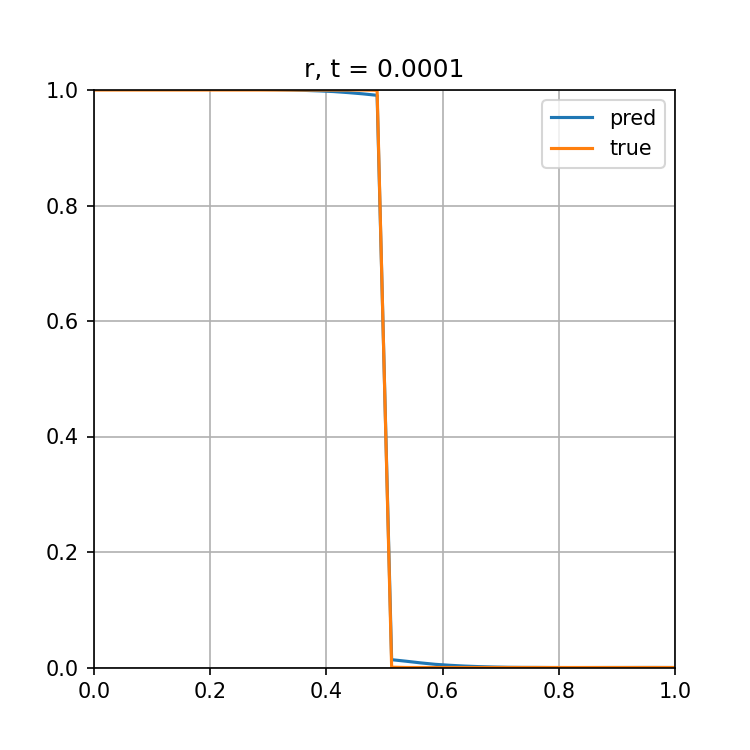

In [52]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
line1, = ax.plot([], [], lw = 1.5, label = "pred")
line2, = ax.plot([], [], lw = 1.5, label = "true")
lines = [line1, line2]
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()
ax.grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	r_hat_pred = r_hat_preds[i]
	r_hat_true = r_hat_trues[i]
	lines[0].set_data(x_test, r_hat_pred)
	lines[1].set_data(x_test, r_hat_true)
	ax.set_title("r, t = {:.4f}".format(t_test[i]))
	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>


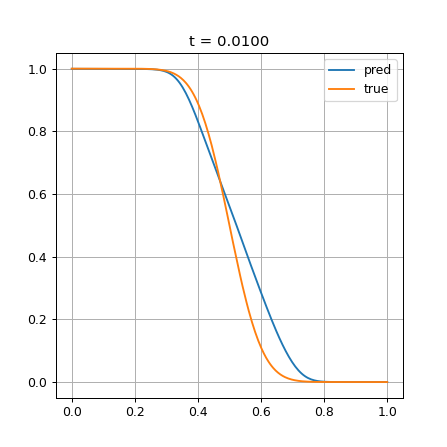

In [34]:
from scipy.io import loadmat
data = loadmat("4_epsilon_1e-8.mat")
x_true_, u_true = data["x"], data["u"]
x_true = np.zeros_like(u_true)
x_true[0] = 0; x_true[-1] = 1
x_true[1:-1] = x_true_

f, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(x_test, r_hat_preds[-1], label = "pred")
ax.plot(x_true, u_true, label = "true")
ax.set_title("t = {:.4f}".format(t_test[-1]))
ax.legend()
ax.grid()
plt.show()

In [ ]:
# from matplotlib import animation
# %matplotlib notebook

# fig, ax = plt.subplots(2, 3, figsize = (15, 10))
# lines = []
# for i in range(2):
# 	for j in range(3):
# 		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
# 		lines.append(line)
# 		ax[i][j].set_xlim([-1, 1])
# 		ax[i][j].set_ylim([-5, 5])
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# ax[0][0].set_ylim([0.9, 2.1])
# ax[1][0].set_ylim([-0.1, 1.0])
    
# def init():
# 	for line in lines:
# 		line.set_data([], [])
# 	return lines

# def animate(i):
# 	u_pred, v_pred = u_preds[i], v_preds[i]
# 	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
# 	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# # 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
# 	lines[0].set_data(x_test, u_pred)
# 	ax[0][0].set_title("u, t = {:.4f}".format(t_test[i]))
# 	lines[1].set_data(x_test, du_dx_pred)
# 	ax[0][1].set_title("du_dx, t = {:.4f}".format(t_test[i]))
# 	lines[2].set_data(x_test, du_dt_pred)
# 	ax[0][2].set_title("du_dt, t = {:.4f}".format(t_test[i]))
    
# 	lines[3].set_data(x_test, v_pred)
# 	ax[1][0].set_title("v, t = {:.4f}".format(t_test[i]))
# 	lines[4].set_data(x_test, dv_dx_pred)
# 	ax[1][1].set_title("dv_dx, t = {:.4f}".format(t_test[i]))
# 	lines[5].set_data(x_test, dv_dt_pred)
# 	ax[1][2].set_title("dv_dt, t = {:.4f}".format(t_test[i]))

# 	return lines

# anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
# plt.show()

In [ ]:
# from scipy.io import loadmat
# data = loadmat("epsilon_0.49.mat")
# x_true, u_true, v_true = data["x"], data["u"], data["v"]

# f, ax = plt.subplots(1, 2, figsize = (12, 5))
# ax[0].plot(x_test, u_preds[-1], label = "pred")
# ax[0].plot(x_true, u_true, label = "true")
# ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
# ax[1].plot(x_test, v_preds[-1], label = "pred")
# ax[1].plot(x_true, v_true, label = "true")
# ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
# for i in range(2):
# 	ax[i].legend()
# 	ax[i].grid()
# plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))